# <b>Anime Recommender System Using Hybrid Filter</b>
<b>Muhammed Rüşen Birben 150220755</b>

## <b>1 - Data Preparing and Understanding</b>

### <b>1.a Preparing Anime Info Dataframes</b>

#### Importing pandas and reading anime csv files

In [1]:
# ALL RELATED LIBRARIES OF THIS NOTEBOOK
# !pip install numpy
# !pip install pandas
# !pip install scikit-learn
# !pip install scipy
# !pip install matplotlib
# !pip install seaborn
# !pip install yake

import pandas as pd
import numpy as np
anime_synopsis = pd.read_csv("data_raw/data/anime_with_synopsis.csv")
anime_df = pd.read_csv("data_raw/data/anime.csv")

#### Getting info for both dfs

In [2]:
anime_df.iloc[:,0:19].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MAL_ID         17562 non-null  int64 
 1   Name           17562 non-null  object
 2   Score          17562 non-null  object
 3   Genres         17562 non-null  object
 4   English name   17562 non-null  object
 5   Japanese name  17562 non-null  object
 6   Type           17562 non-null  object
 7   Episodes       17562 non-null  object
 8   Aired          17562 non-null  object
 9   Premiered      17562 non-null  object
 10  Producers      17562 non-null  object
 11  Licensors      17562 non-null  object
 12  Studios        17562 non-null  object
 13  Source         17562 non-null  object
 14  Duration       17562 non-null  object
 15  Rating         17562 non-null  object
 16  Ranked         17562 non-null  object
 17  Popularity     17562 non-null  int64 
 18  Members        17562 non-n

In [3]:
anime_df.iloc[:,19:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Favorites      17562 non-null  int64 
 1   Watching       17562 non-null  int64 
 2   Completed      17562 non-null  int64 
 3   On-Hold        17562 non-null  int64 
 4   Dropped        17562 non-null  int64 
 5   Plan to Watch  17562 non-null  int64 
 6   Score-10       17562 non-null  object
 7   Score-9        17562 non-null  object
 8   Score-8        17562 non-null  object
 9   Score-7        17562 non-null  object
 10  Score-6        17562 non-null  object
 11  Score-5        17562 non-null  object
 12  Score-4        17562 non-null  object
 13  Score-3        17562 non-null  object
 14  Score-2        17562 non-null  object
 15  Score-1        17562 non-null  object
dtypes: int64(6), object(10)
memory usage: 2.1+ MB


In [4]:
anime_synopsis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16214 entries, 0 to 16213
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   MAL_ID     16214 non-null  int64 
 1   Name       16214 non-null  object
 2   Score      16214 non-null  object
 3   Genres     16214 non-null  object
 4   sypnopsis  16206 non-null  object
dtypes: int64(1), object(4)
memory usage: 633.5+ KB


#### Dropping duplicates for both

In [5]:
before = len(anime_df.index)
anime_df.drop_duplicates(inplace=True)
after = len(anime_df.index)
print(f"Before anime {before}\nAfter anime {after}")

before = len(anime_synopsis.index)
anime_synopsis.drop_duplicates(inplace=True)
after = len(anime_synopsis.index)
print(f"Before anime_synopsis {before}\nAfter anime_synopsis {after}")
del after, before

Before anime 17562
After anime 17562
Before anime_synopsis 16214
After anime_synopsis 16214


#### Renaming columns of dfs

In [6]:
print(anime_df.columns)
print("Feature num: ",anime_df.shape[1])
anime_df.rename(columns={"English name":"english_name", "Japanese name":"japanese_name",
 "On-Hold":"on_hold", "Plan to Watch":"plan_to_watch", "MAL_ID":"anime_id"}, inplace=True)
anime_df.rename(columns={i:i.replace("-","_") for i in anime_df.columns}, inplace=True)
anime_df.rename(columns={i:i.lower() for i in anime_df.columns}, inplace=True)
print(anime_df.columns)

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'],
      dtype='object')
Feature num:  35
Index(['anime_id', 'name', 'score', 'genres', 'english_name', 'japanese_name',
       'type', 'episodes', 'aired', 'premiered', 'producers', 'licensors',
       'studios', 'source', 'duration', 'rating', 'ranked', 'popularity',
       'members', 'favorites', 'watching', 'completed', 'on_hold', 'dropped',
       'plan_to_watch', 'score_10', 'score_9', 'score_8', 'score_7', 'score_6',
       'score_5', 'score_4', 'score_3', 'score_2', 'score_1'],
      dtype='object')


In [7]:
print(anime_synopsis.columns)
print("Feature num: ",anime_synopsis.shape[1])
anime_synopsis.rename(columns={"MAL_ID":"anime_id", "sypnopsis":"synopsis"}, inplace=True)
anime_synopsis.rename(columns={i:i.replace("-","_") for i in anime_synopsis.columns}, inplace=True)
anime_synopsis.rename(columns={i:i.lower() for i in anime_synopsis.columns}, inplace=True)
print(anime_synopsis.columns)

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'sypnopsis'], dtype='object')
Feature num:  5
Index(['anime_id', 'name', 'score', 'genres', 'synopsis'], dtype='object')


#### Filter Adult Content

In [8]:
# will use adult_anime_ids for filtering the ratings of adult animes later on
adult_anime_ids = anime_df[anime_df['rating'] == 'Rx - Hentai']['anime_id'] # Rx-Hentai is basically P*rn* in anime style
anime_df = anime_df[anime_df['rating'] != 'Rx - Hentai']
anime_synopsis = anime_synopsis[anime_synopsis.index.isin(anime_df.index)]

#### Fill 'Unknown' With np.nan or Zero for Numeric Values

In [9]:
# NUMERIC
to_int = ["episodes", "score_10","score_9","score_8","score_7","score_6","score_5","score_4","score_3","score_2","score_1"]
to_float = ["score"]

# I have done various experiments with these features, rank seems to be the best
# and the most reliable measure among these.
for i in to_int:
    print(f"feature: {i}, {(anime_df[i] == 'Unknown').sum()} unknown values filled.")
    anime_df[i]= anime_df[i].apply(lambda x: 0 if x == "Unknown" else x)
    anime_df[i] = anime_df[i].astype(float) # "0.0" could not be connverted directly to 0 so first make it float, than int
    anime_df[i] = anime_df[i].astype(int)

for i in to_float:
    print(f"feature: {i}, {(anime_df[i] == 'Unknown').sum()} unknown values filled.")
    anime_df[i]= anime_df[i].apply(lambda x: np.nan if x == "Unknown" else x)
    anime_df[i] = anime_df[i].astype(float)
    anime_synopsis[i]= anime_synopsis[i].apply(lambda x: np.nan if x == "Unknown" else x)
    anime_synopsis[i] = anime_synopsis[i].astype(float)


print(f"feature: ranking, {(anime_df['ranked'] == 'Unknown').sum()} unknown values filled.")
anime_df['ranked'] = anime_df['ranked'].replace('Unknown', np.nan)
anime_df['ranked'] = anime_df['ranked'].astype(float)
anime_df['ranked'] = anime_df['ranked'].fillna(anime_df['ranked'].max()+1)
anime_df['ranked'] = anime_df['ranked'].astype(int)



# STRING

# For the synopsis 'No synopsis information has been added to ...' should be mapped with empty string
# If we will later on use synopsis info these values should be cleansed
no_syn = 'No synopsis information has been added to this title. Help improve our database by adding a synopsis here .'
anime_synopsis.synopsis.replace(no_syn, '', inplace=True)
anime_synopsis.synopsis.fillna('', inplace=True)
print("There are ", len(anime_synopsis.synopsis[anime_synopsis.synopsis == '']), "empty synopsis (snopsis == '') ")

del i, to_float, to_int, no_syn

feature: episodes, 477 unknown values filled.
feature: score_10, 436 unknown values filled.
feature: score_9, 3154 unknown values filled.
feature: score_8, 1364 unknown values filled.
feature: score_7, 501 unknown values filled.
feature: score_6, 509 unknown values filled.
feature: score_5, 582 unknown values filled.
feature: score_4, 974 unknown values filled.
feature: score_3, 1304 unknown values filled.
feature: score_2, 1595 unknown values filled.
feature: score_1, 457 unknown values filled.
feature: score, 5124 unknown values filled.
feature: ranking, 417 unknown values filled.
There are  663 empty synopsis (snopsis == '') 


#### Looking for na

In [10]:
anime_df.isna().sum()[anime_df.isna().sum() != 0] 
# Some score are missing (won't need for content based filtering)

score    5124
dtype: int64

In [11]:
anime_synopsis.isna().sum()[anime_synopsis.isna().sum() != 0] 
# some scores are missing (won't need for content based filtering, in fact for this df we will only use the synopsis column) 

score    4836
dtype: int64

#### Saving as csv

In [12]:
anime_df.to_csv("data_cleansed/anime_info.csv", index=False)
anime_synopsis.to_csv("data_cleansed/anime_synopsis.csv", index=False)
del anime_synopsis
del anime_df

### <b>1.b Preparing Ratings Dataframe</b>

#### Reading the rating dataset & dropping the duplicates

In [13]:
# A large dataset (takes about 1 min to load)
# (might even give an error depending on RAM)
rating_status_comp = pd.read_csv('data_raw/data/rating_complete.csv')
rating_status_comp.drop_duplicates(inplace=True)

#### Looking for info

In [14]:
rating_status_comp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57633278 entries, 0 to 57633277
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 1.7 GB


In [15]:
rating_status_comp.isna().sum()[rating_status_comp.isna().sum() != 0] # No feature with na in it

Series([], dtype: int64)

#### Filtering Adult Anime Ratings

In [16]:
rating_status_comp = rating_status_comp[~rating_status_comp['anime_id'].isin(adult_anime_ids)]
del adult_anime_ids

#### Saving rating files to cvs
Warning: takes too long to save csv

In [17]:
# this step takes a bit long too (1 min 30 sec approx.)
rating_status_comp.to_csv("data_cleansed/ratings.csv", index=False)
del rating_status_comp

### <b>1.c Reading watching status mapping csv</b>

In [18]:
df = pd.read_csv("data_raw/data/watching_status.csv")

In [19]:
print(df) # nothing to clear, can keep these in mind. (i won't need though)
# not worth copying to clensed_data folder
del df

   status         description
0       1  Currently Watching
1       2           Completed
2       3             On Hold
3       4             Dropped
4       6       Plan to Watch


## Cleansed Data Summary:

In [20]:
import os
print("Raw data consisted of these (excluding html folder)")
os.listdir('data_raw/data/')

Raw data consisted of these (excluding html folder)


['anime.csv',
 'animelist.csv',
 'anime_with_synopsis.csv',
 'rating_complete.csv',
 'watching_status.csv']

In [21]:
os.listdir('data_cleansed')

['anime_info.csv', 'anime_synopsis.csv', 'ratings.csv']

 - <b>anime_info.csv:</b> consist of animes' detailed information like genre, studio, airing year, ratings number for each rate degree etc.<br>
 - <b>anime_synopsis.csv:</b> consist of basic info about anime like score and genre. But most importantly it includes the synopsis of anime. (Might use synopsis with term frequency algorithm. Or i might not use it, Haven't decided yet)<br>
 - <b>ratings.csv:</b> includes all of the ratings of users that are given for animes which user actually watched compleatly. (watching_status==2)<br> Watching status is a feature that exist in animelist.csv file. I only considered the subset of animelist.csv which is saved as ratings.csv
* NOTE: I did not use watching_status.csv and animelist.csv as i have only used rating_complete.csv that consist of ratings that are given after watching the anime completely
(watching_status == 2)

## <b>2 -  Data Preprocessing</b>

### 2.a Reading Cleansed Anime and Rating CSVs, Importing Related Libraries

In [93]:
from matplotlib import pyplot as plt
from sklearn import preprocessing
import seaborn as sns
import numpy as np
import pandas as pd
sns.set()

In [94]:
ratings = pd.read_csv('data_cleansed/ratings.csv')
animes = pd.read_csv('data_cleansed/anime_info.csv')

### 2.b Ratings: Removing Outlier Users' Ratings and Unpopular Anime's Ratings, Select Ratings and Normalize

#### Removing Outliers: filter users that give very few (or very  large) number of ratings 

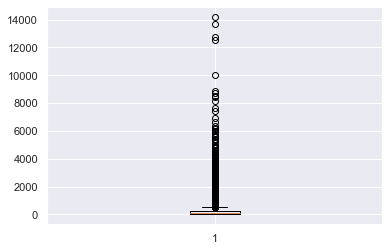

In [95]:
# If a user rated too many anime we consider them as outlier. They might be bots
# Or the opposite is also true, some users are crazy enough to create fake accounts and
# boost the anime they are fan of by giving high scores (resulting in some users giving only a few ratings). We will eliminate them. 
plt.boxplot(ratings.user_id.value_counts())
plt.show()
# bad

In [96]:
# Detecting and filtering out outlier users 
# some users have more than necessary ratings (max user has 15000 ratings. might be even
# a bot, or a real weeb :) and some have very few reviews. we don't want to include them.
temp_df = ratings.user_id.value_counts() # df that holds num of rating for each user

IQR = temp_df.quantile(q=0.75) - temp_df.quantile(q=0.25)
u_bound = (temp_df.quantile(q=0.75) + 1.5*IQR)
l_bound = (temp_df.quantile(q=0.25) - 1.5*IQR)
outlier_filter = temp_df.between(left=l_bound, right=u_bound)


print(f"Before outlier removal user num: {len(temp_df.index)}")
print(f"Before outlier removal rating num: {len(ratings.index)}")
print(f"Before outlier removal rated anime num:\
    {len(ratings.anime_id.value_counts().index)}")
print("########################################################")
print("####################   Outlier Removal   ###############")
print("########################################################")
ratings = ratings[ratings['user_id'].isin((temp_df[outlier_filter]).index)] # filtering

print(f"After outlier removal user num: {len(temp_df[outlier_filter].index)}")
print(f"After outlier removal rating num: {len(ratings.index)}")
print(f"After outlier removal rated anime num:\
    {len(ratings.anime_id.value_counts().index)}")

del temp_df, outlier_filter, IQR, u_bound, l_bound

Before outlier removal user num: 309486
Before outlier removal rating num: 56727080
Before outlier removal rated anime num:    15553
########################################################
####################   Outlier Removal   ###############
########################################################
After outlier removal user num: 289535
After outlier removal rating num: 39653886
After outlier removal rated anime num:    13530


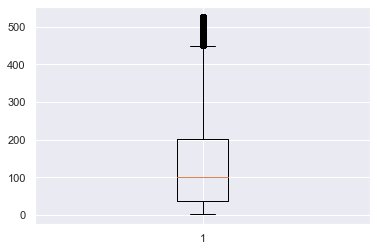

In [97]:
plt.boxplot(ratings.user_id.value_counts())
plt.show()
# better

But there are still users with one or really less number of ratings. They will not provide us any (or very very little) information.

#### Selecting ratings: make sure there aren't any user that give less ratings than the specified threashold

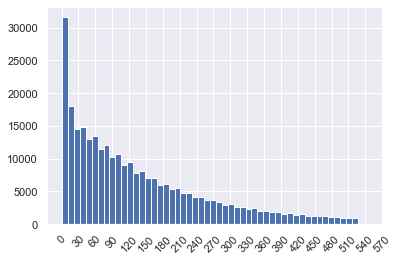

count    289535.000000
mean        136.957142
std         123.338623
min           1.000000
25%          38.000000
50%         101.000000
75%         203.000000
max         527.000000
Name: user_id, dtype: float64

In [98]:
plt.hist(ratings['user_id'].value_counts(),bins=50)
plt.xticks(np.arange(0,600,30), rotation=45)
plt.show()
ratings['user_id'].value_counts().describe()

In [99]:
temp_df = ratings.user_id.value_counts()
temp_rating_filter = temp_df >= 39 # Threshold: > 0.25 percentile
ratings = ratings[ratings['user_id'].isin((temp_df[temp_rating_filter]).index)]
del temp_rating_filter, temp_df

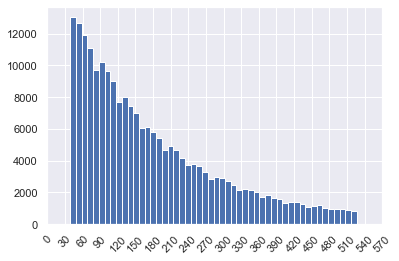

count    217107.000000
mean        177.348985
std         117.137160
min          39.000000
25%          84.000000
50%         144.000000
75%         243.000000
max         527.000000
Name: user_id, dtype: float64

In [100]:
plt.hist(ratings['user_id'].value_counts(),bins=50)
plt.xticks(np.arange(0,600,30), rotation=45)
plt.show()
ratings['user_id'].value_counts().describe()

#### Selecting ratings again: this time for animes that are rated really few times

In [101]:
ratings['anime_id'].value_counts().describe()

count     13504.000000
mean       2851.281546
std        8860.878280
min           1.000000
25%          10.000000
50%         135.000000
75%        1382.250000
max      145879.000000
Name: anime_id, dtype: float64

In [102]:
print(f"Before non populer anime removal user num: {len(ratings.user_id.value_counts().index)}")
print(f"Before non populer anime removal rating num: {len(ratings.index)}")
print(f"Before non populer anime removal rated anime num: {len(ratings.anime_id.value_counts().index)}")

temp_df = ratings['anime_id'].value_counts()
anime_filter = temp_df.quantile(0.25, interpolation='nearest')
temp_df = temp_df[temp_df > int(anime_filter)]
ratings = ratings[ratings['anime_id'].isin(temp_df.index)]

print("\n")
print(f"After non populer anime removal user num: {len(ratings.user_id.value_counts().index)}")
print(f"After non populer anime removal rating num: {len(ratings.index)}")
print(f"After non populer anime removal rated anime num: {len(temp_df.index)}")
del temp_df, anime_filter


Before non populer anime removal user num: 217107
Before non populer anime removal rating num: 38503706
Before non populer anime removal rated anime num: 13504


After non populer anime removal user num: 217107
After non populer anime removal rating num: 38491431
After non populer anime removal rated anime num: 10121


#### Normalizing Ratings

In [103]:
scaler = preprocessing.MinMaxScaler()
ratings['rating'] = scaler.fit_transform(np.array(ratings['rating']).reshape(-1,1))
del scaler

### 2.c Anime Info DataFrame: Selecting Animes (Filter Out Really Unpopuler or Unloved Ones)
By feature engineering & comparing with ratings

#### Feature Engineering and Filtering Based on Created Features
Trying to get two measures: How relevant anime is and how loved is it.

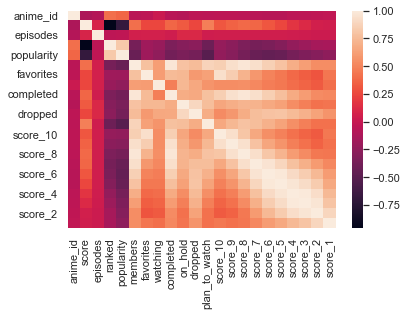

In [104]:
sns.heatmap(animes.corr())
plt.show()

In [105]:
## These two features will be used in relevancy

w = preprocessing.normalize([np.array(animes['watching'])])
p = preprocessing.normalize([np.array(animes['plan_to_watch'])])
o = preprocessing.normalize([np.array(animes['on_hold'])])
c = preprocessing.normalize([np.array(animes['completed'])])
d = preprocessing.normalize([np.array(animes['dropped'])]) # user changed mind and didn't watch: negative

animes.ranked.replace(0,animes.ranked.max()+1, inplace=True)
r_p = preprocessing.normalize([1/np.array(animes['ranked'])]) # r_p: rank point

# popularity and ranking of 2 animes are 0, which is not valid actually (and was not mentioned by the author of the data)
# so i had to fill these values up by manually, i filled them by animes.feature.max() + 1 as i believe if they
# were to be popular they wouldn't have invalid values for popularity
animes.popularity.replace(0,animes.popularity.max()+1, inplace=True)
pp = preprocessing.normalize([1 / np.array(animes['popularity'])])

m = preprocessing.normalize([np.array(animes['members'])])
f = preprocessing.normalize([np.array(animes['favorites'])])

# gave really low score: negative (h: hatred)
h = preprocessing.normalize([np.array(animes[['score_3', 'score_2', 'score_1']].sum(axis=1))]) 

# How many users rated that anime: rate count
rc = preprocessing.normalize([np.array(animes.loc[:,"score_10":"score_1"].sum(axis=1))])

# How many users watched this anime (currently watching, counts more in relevancy) vr: view rate 
vr = w[0] + 0.8*p[0] + 0.6*o[0] + 0.4*c[0] + 0.4*d[0]
vr = preprocessing.normalize([vr])
relevancy_score = vr[0] + rc[0]
relevancy_score = preprocessing.normalize([relevancy_score])
animes['relevancy_score'] = relevancy_score[0]


## This features will be used in love_score
love_score = f[0] + 0.8*pp[0] + 0.6*m[0] + 0.6*r_p[0] - 0.4*d[0] - 0.8*h[0]
love_score = preprocessing.normalize([love_score])
animes['love_score'] = love_score[0]

# dropping other unnecessary columns
del c,w,p,o,d,r_p,pp,m,f,h,rc,vr,relevancy_score,love_score
animes.drop(columns=['ranked'],inplace=True) 
animes.drop(columns=['watching', 'completed', 'on_hold', 'dropped', 'plan_to_watch'],inplace=True)
animes.drop(columns=['score_10', 'score_9', 'score_8', 'score_7', 'score_6',
       'score_5', 'score_4', 'score_3', 'score_2', 'score_1'],inplace=True)
# for score: ranking is already an index based on this, corr=-1 nearly
animes.drop(columns=['score', 'popularity', 'members', 'favorites'],inplace=True)

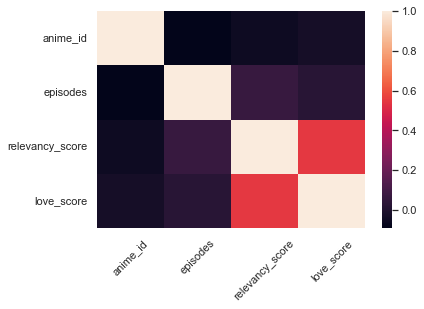

In [106]:
sns.heatmap(animes.corr())
plt.xticks(rotation=45)
plt.show()

In [107]:
animes.corr()
# Not that bad for relevancy and love score correlation, we should've already expected
# that these two scores would be correlated. (features we used were correlated among them)
# High correlation would make our 'good animes to consider' filter too wide 
# low correlation would make the opposite I belive where these two
# metrics are currently is good

,anime_id,episodes,relevancy_score,love_score
anime_id,1.000000,-0.092706,-0.053995,-0.029899
episodes,-0.092706,1.000000,0.066697,0.026479
relevancy_score,-0.053995,0.066697,1.000000,0.546710
love_score,-0.029899,0.026479,0.546710,1.000000


<b>Filtering Animes</b>

In [108]:
filt_1 = animes['love_score']>animes['love_score'].quantile(0.05) # filter based on love score
filt_2 = animes['relevancy_score']>animes['relevancy_score'].quantile(0.05) # filter based on relevancy score (how alive it is)
print("Before the filter, the number of anime is: ",len(animes))
animes = animes[filt_1 & filt_2]
print("After the filter, the number of anime is: ",len(animes))
del filt_1, filt_2

Before the filter, the number of anime is:  16217
After the filter, the number of anime is:  14595


#### Removing animes that are not rated (not in the ratings df) & removing ratings of animes that are not in animes df

In [109]:
print(f"Before filtering by ratings, anime num in anime info df: {len(animes.index)}")
animes = animes[animes['anime_id'].isin(set(ratings.anime_id))]
print(f"After filtering by ratings, anime num in anime info df: {len(animes.index)}\n\n")

# only consider ratings that are in animes dataframe (for collaborative and content based filter consistency)
# This should not effect our df too much but it is better to see how much it changes
print(f"Before filtering rating num: {len(ratings.index)}")
print(f"Before filtering user num that rated: {len(ratings.user_id.unique())}")
print(f"Before filtering anime num: {len(ratings.anime_id.unique())}")
ratings = ratings[ratings.anime_id.isin(animes.anime_id)]
print("")
print(f"After filtering rating num: {len(ratings.index)}")
print(f"After filtering user num that rated: {len(ratings.user_id.unique())}")
print(f"After filtering anime num: {len(ratings.anime_id.unique())}")

Before filtering by ratings, anime num in anime info df: 14595
After filtering by ratings, anime num in anime info df: 9317


Before filtering rating num: 38491431
Before filtering user num that rated: 217107
Before filtering anime num: 10121

After filtering rating num: 31717568
After filtering user num that rated: 217107
After filtering anime num: 9317


### 2.d Creating Encoding and Decoding Dictionaries For Anime and User IDs 

In [110]:
import pickle
user_id_decoding = {i:x for i,x in enumerate(ratings['user_id'].unique())}
user_id_encoding = {x:i for i,x in enumerate(ratings['user_id'].unique())}

anime_id_decoding = {i:x for i,x in enumerate(ratings['anime_id'].unique())}
anime_id_encoding = {x:i for i,x in enumerate(ratings['anime_id'].unique())}
ratings.user_id = ratings.user_id.map(user_id_encoding)
ratings.anime_id = ratings.anime_id.map(anime_id_encoding)
animes.anime_id = animes.anime_id.map(anime_id_encoding)
with open('model_variables/preprocessed_datasets/id_encode_decode.pkl', 'wb') as outp:
    pickle.dump(user_id_decoding, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(user_id_encoding, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(anime_id_decoding, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(anime_id_encoding, outp, pickle.HIGHEST_PROTOCOL)

### 2.e Adding metadata feature to animes using other columns

In [111]:
# I used YAKE (Yet Another Keyword Extraction Algorithm) for extracting info from text
# yake is an implementation of this algorithm in python
# !pip install yake
import yake

# Only the 'synopsis' column will be used from this df. We know that this column is in correct form
# there is '' for no synopsis
animes_w_synopsis = pd.read_csv('data_cleansed/anime_synopsis.csv')
animes_w_synopsis = animes_w_synopsis[animes_w_synopsis['name'].isin(animes['name'])]
animes_w_synopsis.anime_id = animes_w_synopsis.anime_id.map(anime_id_encoding)
animes = pd.merge(animes, animes_w_synopsis[['anime_id','synopsis']], on="anime_id", how="left")
animes.synopsis.fillna('', inplace=True) # for animes that don't correspond to animes_w_synopsis
del animes_w_synopsis


# initilaze empty string for all animes' meta data combined string
animes['meta_combined'] = ''


basic_str_op_lst = ['studios', 'producers', 'licensors', 'genres', 'type', 'source']
feature_weigths = {'studios':1, 'producers':1, 'licensors':1, 'genres':2, 'type':2, 'source':1}

for col in basic_str_op_lst:
    animes[col] = animes[col].str.replace(" ","")
    animes[col] = animes[col].str.replace(","," ")
    animes[col].replace('Unknown', '', inplace=True)
    animes[col] = animes[col].str.lower()


In [112]:
def get_meta_combined(row):
    phrase = ''
    for feature in basic_str_op_lst:
        text = row[feature]
        if text == "":
            continue
        phrase += " " +  " ".join([text]*feature_weigths[feature]).strip()
        
    text = row['synopsis']
    language = "en"
    max_phrase_size = 1
    num_of_words = 15
    
    y = yake.KeywordExtractor(lan=language, n=max_phrase_size, top=num_of_words, features=None)
    
    key_words = y.extract_keywords(text)
    
    for word in key_words:
        phrase += " " + word[0].strip()
        
    return phrase.strip()
    

animes['meta_combined'] = animes.apply(get_meta_combined, axis=1)
animes['meta_combined'] = animes['meta_combined'].str.lower()
animes.sort_values(by='anime_id', ascending=True, inplace=True)

In [113]:
# One might one to save these, because otherwise we'll change these elements for model building

if not os.path.exists("model_variables/preprocessed_datasets"):
    os.mkdir("model_variables/preprocessed_datasets/")
animes.to_csv("model_variables/preprocessed_datasets/animes.csv", index=False)
ratings.to_csv("model_variables/preprocessed_datasets/ratings.csv", index=False)

## <b>3 - Model Building </b>

### 3.a Creating User-Item Matrix: Collaborative Filtering
Warning: This step also takes a bit long (approx 3 to 5 minutes)

In [114]:
# This step takes a bit long even with threading (approx 3-5 minutes)
import concurrent.futures
x = len(ratings.groupby('user_id'))
y = len(ratings.groupby('anime_id'))


# our ratings now is only a numpy array (for efficiency purpouses)
ratings = np.array(ratings)


user_item_matrix = np.empty((x, y)) # init empty matrix
user_item_matrix.fill(np.nan)

def create_user_item_matrix(anime):
    """
    For inputted anime this function calculates and assigns to (user-item)
    the ratings of users that rated
    """
    global user_item_matrix
    users = np.arange(0,x) # represents users (since ids are mapped to 0-x)
    anime_rating_v = ratings[ratings[:,1] == anime] # ratings vector that include that particular anime id (given in the func param)
    # assign users (which gave that rating) rating in the matrix to that rating 
    user_item_matrix[np.isin(users, anime_rating_v[:,0]), anime] = anime_rating_v[:,2] 

with concurrent.futures.ThreadPoolExecutor() as executer:
    for anime in np.unique(ratings[:,1]).astype(int): # For unique anime ids in the ratings df
        executer.submit(create_user_item_matrix, anime) # submit that execution of func with the param

np.save('model_variables/user_item_matrix.npy',user_item_matrix)
# IMPORTANT: we are getting rid of 'ratings' since we now have user-item matrix
# we also removed user-item matrix as we've saved it into our hard disc
del ratings, x, y, user_item_matrix, anime, executer

### 3.b Creating Anime-Similarity Matrix From Anime Meta Data: Content Based Filtering

In [115]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
count_term = CountVectorizer()

count_matrix = count_term.fit_transform(animes['meta_combined'])
cosine_sim = cosine_similarity(count_matrix, count_matrix)
np.save('model_variables/anime_similarity_matrix.npy',cosine_sim)
del cosine_sim, count_matrix, count_term, animes

## <b>4 - Building Hybrid Filter / Define Recommendation Functions</b>

### 4.a Defining Functions For Content Based Filtering

In [116]:
def get_meta(name: str):
    import pandas as pd
    if 'animes' not in locals().keys():
        animes = pd.read_csv("model_variables/preprocessed_datasets/animes.csv")
    else:
        animes = locals()['animes']

    a = animes[animes['name'].str.lower() == name.lower()]
    if len(a.index)!= 0:
            a = a.iloc[0]
    else:
        try:
            a = animes[animes.name.str.lower().str.contains(name.lower(),
             regex=False)].iloc[0]
        except IndexError:
            print('anime not found')
            return -1
    
    return (a['name'], a['meta_combined'])

def get_synopsis(name: str):
    import pandas as pd
    if 'animes' not in locals().keys():
        animes = pd.read_csv("model_variables/preprocessed_datasets/animes.csv")
    else:
        animes = locals()['animes']

    a = animes[animes['name'].str.lower() == name.lower()]
    if len(a.index)!= 0:
            a = a.iloc[0]
    else:
        try:
            a = animes[animes.name.str.lower().str.contains(name.lower(),
             regex=False)].iloc[0]
        except IndexError:
            print('anime not found')
            return -1
    
    return (a['name'], a['synopsis'])

def get_recommendations_content_based(name: str):
    import numpy as np
    import pandas as pd
    if 'animes' not in locals().keys():
        animes = pd.read_csv("model_variables/preprocessed_datasets/animes.csv")
    else:
        animes = locals()['animes']
    
    if 'cosine_sim' not in locals().keys():
        cosine_sim = np.load("model_variables/anime_similarity_matrix.npy")

    else:
        cosine_sim = locals()['cosine_sim']
    import pandas as pd

    a = animes[animes['name'].str.lower() == name.lower()]
    if len(a.index)!= 0:
            a = a.iloc[0]
    else:
        try:
            a = animes[animes.name.str.lower().str.contains(name.lower(),
             regex=False)].iloc[0]
        except IndexError:
            print('anime not found')
            return -1
    
    print(f"recommendations for {a['name']}:")
    print("\n\n")
    id_encoded = a.anime_id
    similarities_vector = cosine_sim[id_encoded]
    ind = np.argpartition(similarities_vector, -11)[-11:]
    for enc_anm_id in np.flip(ind[np.argsort(similarities_vector[ind])])[1:]:
        err  = round(1-similarities_vector[enc_anm_id],3)
        print(animes.name[animes.anime_id == enc_anm_id].iloc[0],"-->", "with an error of", err)
    
    return 0
    

## <b>5 - Main Program</b>

In [132]:
get_recommendations_content_based("Doraemon")


recommendations for Doraemon:



Doraemon (1979) --> with an error of 0.517
Saru Getchu: On Air --> with an error of 0.574
Doraemon Movie 30: Nobita no Ningyo Daikaisen --> with an error of 0.595
Doraemon: It's Winter! --> with an error of 0.597
Doraemon: It's Summer! --> with an error of 0.597
Doraemon: Treasure of the Shinugumi Mountain --> with an error of 0.597
Doraemon: Ganbare! Gian!! --> with an error of 0.597
Doraemon: It's Spring! --> with an error of 0.597
Doraemon: It's Autumn! --> with an error of 0.597
Doraemon Movie 07: Nobita to Tetsujin Heidan --> with an error of 0.6


0

In [118]:
get_recommendations_content_based("One Piece")

recommendations for One Piece: Yume no Soccer Ou!:



One Piece: Mezase! Kaizoku Yakyuu Ou --> with an error of 0.455
One Piece: Jango no Dance Carnival --> with an error of 0.555
Kinnikuman: Ooabare! Seigi Choujin --> with an error of 0.583
One Piece Movie 5: Norowareta Seiken --> with an error of 0.583
Nissan Serena x One Piece 3D: Mugiwara Chase - Sennyuu!! Sauzando Sanii-gou --> with an error of 0.583
One Piece Movie 3: Chinjuu-jima no Chopper Oukoku --> with an error of 0.592
One Piece Movie 4: Dead End no Bouken --> with an error of 0.592
One Piece Film: Strong World --> with an error of 0.613
Dr. Slump Movie 06: Arale-chan N-cha! Penguin Mura wa Hare Nochi Hare --> with an error of 0.614
Yu☆Gi☆Oh! (Movie) --> with an error of 0.617


0

In [133]:
get_meta("Saru Getchu: On Air")


('Saru Getchu: On Air',
 'xebec adventure comedy fantasy kids romance shounen tv game')

In [120]:
get_meta("jujutsu")

('Jujutsu Kaisen',
 'yokohamaanimationlab shounen ona manga jujutsu curses humans gojou fiendish spirits invisible normal fear ryoumen sukuna itadori yuuji satoru school')

In [121]:
a = pd.read_csv("data_raw/data/rating_complete.csv")